## SECOND ML EXPERIMENT
#### WITH CPU AND SKLEARN

TARGET created by MEAN of **SUCCESS SCORE 2** which uses INFLUENCER SCORE as the following:

> $$ Influencer = \left(RI\over {fans} \right) $$


For more information see notebook _Feature Engineering 3.ipynb_

**We exclude CANADA from the training**

**XGB BOOST AS BEST PERFOMANT MODEL**

**USING RANDOMIZED SEARCH FOR HYPERPARAMETER TUNING**

Best parameters found:  {'subsample': 0.3, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree_vals': 0.8}

Best accuracy found:  0.8489117395029991

In [ ]:
!pip install plotly

In [2]:
import pandas as pd
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
import xgboost as xgb

#from functions import run_exps

import wandb

import warnings
warnings.filterwarnings('ignore') 

In [3]:
business = pd.read_csv('./data/business.csv')
attributes = pd.read_csv('./data/atributtes_clean.csv', low_memory=False)
categories = pd.read_csv('./data/categories_fixed.csv')
hours = pd.read_csv('./data/hours_fixed.csv')
gps = pd.read_csv('./data/gps_clustering.csv')
checkins = pd.read_csv('./data/n_checkins.csv')
top_tips = pd.read_csv('./data/top_tips.csv')
target1 = pd.read_csv('./data/target.csv')
target2 = pd.read_csv('./data/target2.csv')
sentiment = pd.read_csv('./data/sentiment/sentiment_ok_unique.csv')

In [71]:
data_frames = [business, attributes, categories, hours, gps, checkins, top_tips, target2]
full_data_2 = reduce(lambda left,right: pd.merge(left,right,on='business_id', how='left'), data_frames)

In [6]:
full_data_2.shape

(150346, 51)

In [7]:
full_data_2.columns

Index(['business_id', 'name', 'postal_code', 'latitude_x', 'longitude_x',
       'stars', 'review_count', 'is_open', 'good_ambience', 'garage',
       'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'BikeParking',
       'WiFi', 'delivery', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsReservations', 'HasTV', 'RestaurantsGoodForGroups',
       'Alcohol', 'ByAppointmentOnly', 'Caters', 'RestaurantsAttire',
       'NoiseLevel', 'meal_diversity', 'Restaurants', 'Food', 'Shopping',
       'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical',
       'Local Services', 'Bars', 'Automotive', 'total_categories', '7days',
       'weekends', 'n_open_days', 'mean_total_hours_open', 'mean_open_hour',
       'mean_close_hour', 'latitude_y', 'longitude_y', 'areas',
       'number_visits', 'number_tips', 'Unnamed: 0', 'success_score_2',
       'target'],
      dtype='object')

In [72]:
to_drop = ['name', 'postal_code', 'latitude_x', 'longitude_x', 'stars', 'review_count', 'is_open', 'latitude_y', 'longitude_y',  'number_visits', 'number_tips', 'Unnamed: 0', 'success_score_2', '7days', 'n_open_days', 'total_categories', 'mean_open_hour', 'mean_close_hour' ]
full_data_2.drop(to_drop, inplace=True, axis=1)

In [73]:
full_data_2 = full_data_2.loc[full_data_2['areas'] != 7, :]

<AxesSubplot:>

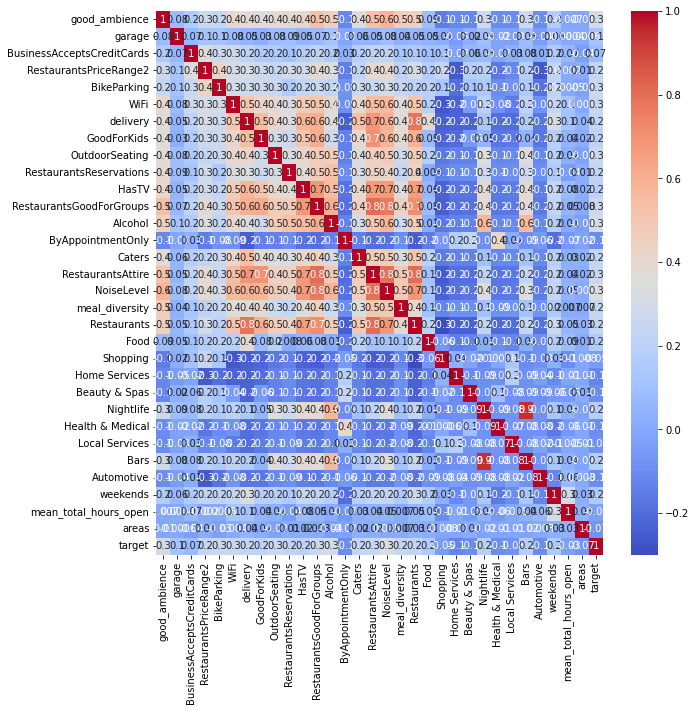

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(full_data_2.corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm')

In [74]:
full_data_2.index = full_data_2['business_id']
full_data_2.drop('business_id', axis=1, inplace=True)

In [56]:
full_data_2.isna().sum()

good_ambience                   0
garage                          0
BusinessAcceptsCreditCards      0
RestaurantsPriceRange2          0
BikeParking                     0
WiFi                            0
delivery                        0
GoodForKids                     0
OutdoorSeating                  0
RestaurantsReservations         0
HasTV                           0
RestaurantsGoodForGroups        0
Alcohol                         0
ByAppointmentOnly               0
Caters                          0
RestaurantsAttire               0
NoiseLevel                      0
meal_diversity                  0
Restaurants                   100
Food                          100
Shopping                      100
Home Services                 100
Beauty & Spas                 100
Nightlife                     100
Health & Medical              100
Local Services                100
Bars                          100
Automotive                    100
weekends                        0
mean_total_hou

In [75]:
# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

full_data_2['mean_total_hours_open'] = mice_imputer.fit_transform(full_data_2['mean_total_hours_open'].values.reshape(-1,1))

In [76]:
full_data_2.fillna(0, inplace=True)

In [59]:
full_data_3 = full_data_2.copy()

In [77]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['areas', 'RestaurantsPriceRange2']
X = ohe.fit_transform(full_data_2[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names_out(to_transform), index=full_data_2.index)
full_data_2 = pd.concat([full_data_2, X], axis=1)
full_data_2.drop(to_transform, axis=1, inplace=True)

In [78]:
full_data_2.shape

(145875, 45)

In [79]:
full_data_2.isna().sum().sum()

0

In [81]:
full_data_2.columns

Index(['good_ambience', 'garage', 'BusinessAcceptsCreditCards', 'BikeParking',
       'WiFi', 'delivery', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsReservations', 'HasTV', 'RestaurantsGoodForGroups',
       'Alcohol', 'ByAppointmentOnly', 'Caters', 'RestaurantsAttire',
       'NoiseLevel', 'meal_diversity', 'Restaurants', 'Food', 'Shopping',
       'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical',
       'Local Services', 'Bars', 'Automotive', 'weekends',
       'mean_total_hours_open', 'target', 'areas_0', 'areas_1', 'areas_2',
       'areas_3', 'areas_4', 'areas_5', 'areas_6', 'areas_8', 'areas_9',
       'areas_10', 'RestaurantsPriceRange2_0', 'RestaurantsPriceRange2_1',
       'RestaurantsPriceRange2_2', 'RestaurantsPriceRange2_3',
       'RestaurantsPriceRange2_4'],
      dtype='object')

In [83]:
wandb.init(project="henry-tf-g2-ml1")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [86]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
        '''
        Lightweight script to test many models and find winners
        :param X_train: training split
        :param y_train: training target vector
        :param X_test: test split
        :param y_test: test target vector
        :return: DataFrame of predictions
        '''
        
        dfs = []

        #dt = DecisionTreeClassifier(max_depth=1)

        models = [
                ('LogReg', LogisticRegression()), 
                ('RF', RandomForestClassifier()),
                ('KNN', KNeighborsClassifier()),
                ('GNB', GaussianNB()),
                ('XGB', XGBClassifier()),
                ('ADA', AdaBoostClassifier())
                ]
        results = []
        names = []

        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

        target_names = ['business_fail','business_success']

        for name, model in models:
                kfold = KFold(n_splits=5, shuffle=True, random_state=90210)
                cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
                clf = model.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                print(name)
                print(classification_report(y_test, y_pred))#, target_names=target_names))
                results.append(cv_results)
                names.append(name)
                this_df = pd.DataFrame(cv_results)
                this_df['model'] = name
                dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
        return final

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_2.drop('target', axis=1), full_data_2['target'], test_size=0.2,
    random_state=42, stratify=full_data_2['target'])

In [88]:
final = run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

           0       0.86      0.96      0.90     23504
           1       0.66      0.33      0.44      5671

    accuracy                           0.84     29175
   macro avg       0.76      0.65      0.67     29175
weighted avg       0.82      0.84      0.82     29175

RF
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     23504
           1       0.60      0.42      0.50      5671

    accuracy                           0.83     29175
   macro avg       0.74      0.68      0.70     29175
weighted avg       0.82      0.83      0.82     29175

KNN
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     23504
           1       0.61      0.40      0.48      5671

    accuracy                           0.83     29175
   macro avg       0.74      0.67      0.69     29175
weighted avg       0.82      0.83      0.82     29175

GNB
 

In [89]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics


## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')


## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

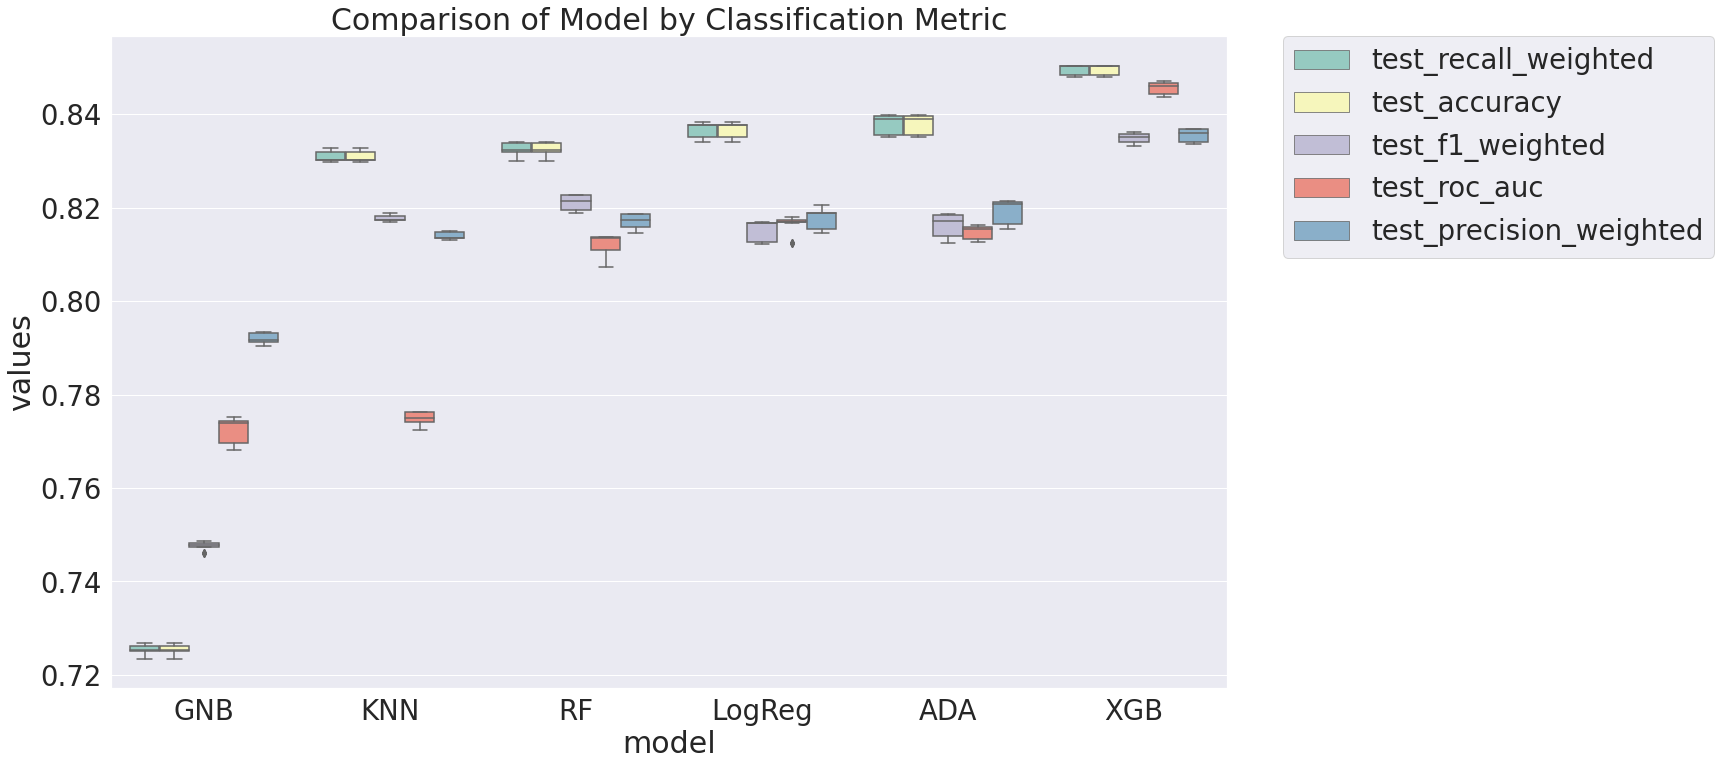

In [90]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

In [91]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_precision_weighted           test_accuracy           test_roc_auc  \
                           std      mean           std      mean          std   
model                                                                           
ADA                   0.002649  0.819174      0.002037  0.837805     0.001414   
GNB                   0.001197  0.792006      0.001086  0.725396     0.002740   
KNN                   0.000801  0.813940      0.001148  0.831057     0.001206   
LogReg                0.002289  0.817803      0.001627  0.836775     0.001889   
RF                    0.001476  0.817134      0.001298  0.832554     0.002221   
XGB                   0.001380  0.835538      0.001058  0.849619     0.001384   

                 test_recall_weighted           test_f1_weighted            
            mean                  std      mean              std      mean  
model                                                                       
ADA     0.814946             0.002037  0.837805         0.002551  0.816226  
GNB     0.772533             0.001086  0.725396         0.000863  0.747642  
KNN     0.774876             0.001148  0.831057         0.000718  0.817746  
LogReg  0.816509             0.001627  0.836775         0.001997  0.815143  
RF      0.811969             0.001298  0.832554         0.001480  0.821155  
XGB     0.845525             0.001058  0.849619         0.001072  0.834910

In [93]:
gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
                'n_estimators': [10,20,50,100,200],
                'subsample': [0.3, 0.5, 0.9],
                'colsample_bytree_vals' : [0.1, 0.5, 0.8, 1],
                'max_depth': [2, 5, 10]
                }


gbm = xgb.XGBClassifier(objective='binary:logistic')

#grid_class = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid, scoring='accuracy', cv=3, verbose=1)
grid_class = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid, scoring='accuracy', cv=3, verbose=1, n_iter=50, n_jobs=-1)

grid_class.fit(X_train, y_train)

print("Best parameters found: ",grid_class.best_params_)

print("Best accuracy found: ", grid_class.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[16:37:06] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:37:08] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:37:09] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but


[16:39:46] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:39:47] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:39:48] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p